<h1>Matrix completion and reccomender systems</h1>
<p>MovieLens datasets were collected by the GroupLens Research Project at the University of Minnesota.
This data set consists of:</p>
<ul>
<li>100,000 ratings (1-5) from 943 users on 1682 movies.</li>
<li>Each user has rated at least 20 movies.</li>
</ul>
<p>The movielens.csv file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly ordered. <br>This is a tab separated list of user id | item id | rating | timestamp.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

Read the dataset from the movielens.csv file

In [ ]:
dataset = pd.read_csv('movielens.csv', sep='\t', header=None)
dataset.describe()

How many movies? How many users? How many ratings?

In [ ]:
movies = dataset[1]
ratings = dataset[2]
users = dataset[0]

n_movies = movies.unique().size
n_users = users.unique().size
n_ratings = ratings.unique().size

Shuffle the data (see the function np.random.shuffle).

In [ ]:
np.random.seed(0)
idxs = np.arange(len(dataset))
np.random.shuffle(idxs)

movies = movies[idxs]
ratings = ratings[idxs]
users = users[idxs]

Split the dataset into a subset of 80,000 training and 20,000 testing ratings.

In [ ]:
n_training = int(0.8 * len(dataset))

users_train = users[:n_training] - 1
movies_train = movies[:n_training] - 1
ratings_train = ratings[:n_training]

users_test = users[n_training:] - 1
movies_test = movies[n_training:] - 1
ratings_test = ratings[n_training:]

Let us denote by $\Omega$ the set of pairs (i, j) such that the rating of the i-th user on the j-th movie is available in the training set (similarly, $\Omega_test$ is the set of testing pairs). Let us denote by $r_{ij}$ the corresponding rating.
<br>
Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:
$$
X_{ij} = \begin{cases}
r_{ij} & \text{if } (i, j) \in \Omega \\
0 & \text{otherwise}
\end{cases}
$$

In [ ]:
X_sparse = csr_matrix((ratings_train, (users_train, movies_train)), shape=(n_users, n_movies))
X_full = X_sparse.toarray()

<h1>Trivial recommender system</h1>
Create a trivial recommender system, based on the average rating of each user:

$$
r^{pred}_{ij} = \frac{1}{N_i} \sum_{j:(i,j)\in \Omega} r_{ij}
$$

where $N_i$ = card $\{j:(i,j)\in \Omega\}$ is the number of ratings of user i in the training set.
<br>
Then compute the RSME (Root Mean Square Error) on the test set:

$$
\text{RMSE} = \sqrt{\frac{1}{card(|\Omega_{test}|)} \sum_{(i,j)\in \Omega_{test}} (r_{ij} - r^{pred}_{ij})^2}
$$

and the Pearson correlation coefficient $\rho$ (use the function scipy.stats.pearsonr).

$$
\rho = \frac{\sum_{(i,j)\in \Omega_{test}} (r_{ij} - \bar{r}) (r^{pred}_{ij} - \bar{r}^{pred})}{\sqrt{\sum_{(i,j)\in \Omega_{test}} (r_{ij} - \bar{r})^2} \sqrt{\sum_{(i,j)\in \Omega_{test}} (r^{pred}_{ij} - \bar{r}^{pred})^2}}
$$

where

$$
\bar{r} = \frac{1}{card(|\Omega_{test}|)} \sum_{(i,j)\in \Omega_{test}} r_{ij}
$$

$$
\bar{r}^{pred} = \frac{1}{card(|\Omega_{test}|)} \sum_{(i,j)\in \Omega_{test}} r^{pred}_{ij}
$$

In [ ]:
avg_rating = np.array([np.mean(ratings_train[users_train == i]) for i in range(n_users)])

#avg_ratings = []
#for i in range(n_users):
#    users_i_ratings = ratings_train[users_train == i]
#    avg_ratings.append(np.mean(users_i_ratings))

rating_prediction_baseline = avg_rating[users_test]
error_baseline = rating_prediction_baseline - ratings_test

def RMSE(e):
    return np.sqrt(np.mean(e**2))

RSME_baseline = RMSE(error_baseline)
rho_baseline = pearsonr(rating_prediction_baseline, ratings_test)

<h1>Singular value truncation (SVT) based recommender system</h1>
Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.
<br>
Try to calibrate the threshold to get better results.

In [ ]:
nmax_iter = 100
threshold = 100.0
increment_toll =1e-3

RMSE_svt = []
rho_svt = []

X = np.copy(X_full)
for i in range(nmax_iter):
    #SVT iteration
    X_old = np.copy(X)
    U, s, VT = np.linalg.svd(X, full_matrices=False)

    s[s<threshold] = 0
    X = U @ np.diag(s) @ VT
    X[users_train, movies_train] = X_full[users_train, movies_train]
    increment = np.linalg.norm(X - X_old)

    #Evaluate X^k
    predicted_ratings = X[users_test, movies_test]
    error = predicted_ratings - ratings_test
    RMSE_svt.append(RMSE(error))
    rho_svt.append(pearsonr(predicted_ratings, ratings_test)[0])

    #Print the iteration
    print(f'Iteration {i+1}/{nmax_iter} RMSE={RMSE_svt[-1]} rho={rho_svt[-1]} increment={increment}')

    #Exit condition
    if increment < increment_toll:
        break

<h1>Moore-Penrose pseudo inverse</h1>

In [16]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

#Write a function that computes the Moore-Penrose pseudoinverse of a matrix, exploiting its SVD decomposition.
def my_pinv_fullSVD(A):
    U, s, VT = np.linalg.svd(A, full_matrices=True)
    s[s>0]=1/s[s>0]
    return VT.T @ la.diagsvd(s, VT.shape[1], VT.shape[0]) @ U.T

#Write now a function that computes the Moore-Penrose pseudoinverse of a matrix, exploiting the reduced SVD decomposition.
def my_pinv_thinSVD(A):
    U, s, VT = np.linalg.svd(A, full_matrices=False)
    s[s>0]=1/s[s>0]
    return VT.T @ np.diag(s) @ U.T


Generate a random matrix A (with elements sampled from a standard Gaussian distribution) with 5 rows and 4 columns. Compute its Moore-Penrose pseudo inverse through the two functions above defined, and compare the results with the function numpy.linalg.pinv.

In [ ]:
A = np.random.randn(5, 4)
Apinv_np = np.linalg.pinv(A)
Apinv_thin = my_pinv_thinSVD(A)
Apinv_full = my_pinv_fullSVD(A)

print(np.linalg.norm(Apinv_np - Apinv_thin) / np.linalg.norm(Apinv_np))
print(np.linalg.norm(Apinv_np - Apinv_full) / np.linalg.norm(Apinv_np))

Compare the three implementations through the command %timeit.

In [12]:
%timeit np.linalg.pinv(A)

12.9 μs ± 168 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [17]:
%timeit my_pinv_thinSVD(A)

10.9 μs ± 140 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%timeit my_pinv_fullSVD(A)

<h1>Least-square regression</h1>
Consider the linear model

$$
y = mx + q
$$

where m=2 and q=3.
<br>
Generate N=100 points $x_i$, sampling from a standard Gaussian distribution, and the associated $y_i$. Then, add a synthetic noise $\epsilon_i$ by sampling from a Gaussian distribution with zero mean and standard variation $\sigma=2$. Plot the noisy data $(x_i, \tilde{y}_i)$, where $\tilde{y}_i = y_i + \epsilon_i$, in the (x, y) plane, toghether with the line y=mx+q.

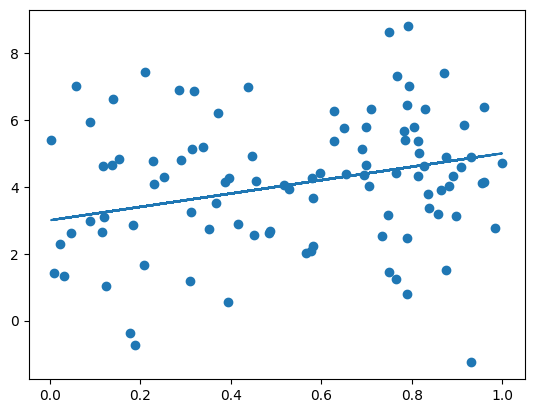

In [20]:
m = 2.0
q = 3.0
N = 100
noise = 2.0

X = np.random.rand(N)
Y = m*X + q + noise*np.random.randn(N)

plt.scatter(X, Y)
plt.plot(X, m*X+q)

Use the previously implemented function to compute the Moore-Penrose pseudo inverse, solve the last-squares problem

$$
\min_{m, q} \sum_{i=1}^N (\tilde{y}_i - (mx_i + q))^2
$$

and display the regression line superimposed to the noisy data and the exact model.
<br>
Repeat the excercise by solving the normal equations. Compare the results

In [ ]:
Phi = np.hstack((X[:, np.newaxis], np.ones((N, 1))))
w = my_pinv_thinSVD(Phi) @ Y
print(f"predicted m: {w[0]:.2t}, correct m: {m}")
print(f"predicted q: {w[1]:.2f}, correct q: {q}")

plt.scatter(X, Y)
plt.plot(X, m * X + q, 'r--')
plt.plot(X, m * X + q, 'g: ')

w2 = np.linalg.solve(Phi.T @ Phi, Phi.T @ Y)
print(np.linalg.norm(w-w2))

<h1>Ridge regression and Kernel regression</h1>
Consider the matrix

$$
y = f(x) = tanh(2x-1)
$$

Generate N=100 points $x_i$, sampling from a standard Gaussian distribution, and the associated $y_i$. Then, add a synthetic noise $\epsilon_i$ by sampling from a Gaussian distribution with zero mean and standard deviation $\sigma=0.1$. Plot the noisy data $(x_i, \tilde{y}_i)$, where $\tilde{y}_i = y_i + \epsilon_i$, in the (x, y) plane.
<br>
Then, generate 1000 testing points, uniformly distributed in the interval [-3, 3], and display the function $y=f(x)$ in correspondence of the testing points.

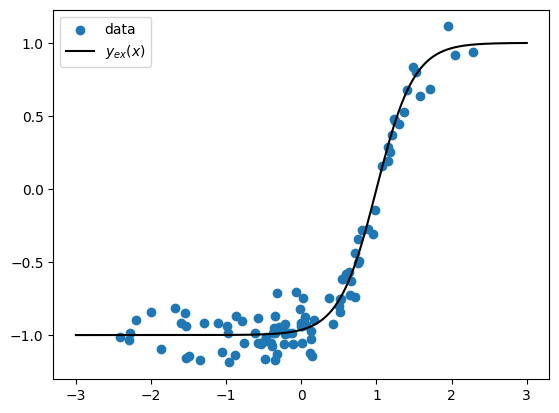

In [25]:
N = 100
noise = 0.1
y_ex = lambda x: np.tanh(2*(x-1))

X = np.random.randn(N)
Y = y_ex(X) + noise*np.random.randn(N)

N_test = 1000
X_test = np.linspace(-3, 3, N_test)
Y_test = y_ex(X_test)

plt.scatter(X, Y, label='data')
plt.plot(X_test, Y_test, color='black', label='$y_{ex}(x)$')
plt.legend()

Proceeding as in the previous excercise, compute the regression line resulting from the least squares regression of data $(x_i, \tilde{y}_i)$. Plot the resulting regression line.<br>
Let us now consider ridge regression, corresponding to a regularization parameter $\lambda=1.0$. Compare the obtained regression line with the one obtained through least squares regression.<br>

In [ ]:
lam = 10.0
alpha = np.linalg.solve(Phi @ Phi.T + lam * np.eye(N), Y)
w = Phi.T @ alpha

Phi_test = np.hstack([X_test[:, None], np.ones ((N_test, 1) )])
Y_test = Phi_test @ w

plt.scatter(X, Y, label="data") 
plt.plot(X_test, Y_test_ex, "r--", label="$y_{ex}(x)$")
plt.plot(X_test, Y_test, "g:", label="Ridge regression")

plt.legend()

Consider now kernel regression.
<br>
1. Consider first the scalar product kernel

$$
K(x_i, x_j) = x_i x_j + 1
$$

Compute the regression function and compare the result with the ones obtained at the previous point. How to the results compare?
<br>
2. Consider then the higher-order scalar product kernel, for q > 1.

$$
K(x_i, x_j) = (x_i x_j + 1)^q.
$$

3. Consider finally a Gaussian kernel, for $\sigma > 0$.

$$
K(x_i, x_j) = e^{-\frac{(x_i - x_j)^2}{2\sigma^2}}
$$

In [ ]:
lam = 1.0

def kernel(xi, xj):
    return (xi*xj + 1) **6

K = np. array ([[kernel(X[i], X[j]) for j in range(N)] for i in range (N)])
alpha = np.linalg.solve(K + lam * np.eye(N), Y)
K_test = np. array ([[kernel(X_test[i], X[j]) for j in range(N)] for i in range(N_test)])
Y_test_KR = K_test @ alpha

plt.scatter(X, Y, label="data") 
plt.plot(X_test, Y_test_ex, "r--", label="$y_{ex}(x)$")
plt.plot(X_test, Y_test, "g:", label="Ridge regression")
plt.plot(X_test, Y_test_KR, "b:", label="Kernel regression")

plt.legend()